# National Numbers
A notebook to look at national numbers

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
try:
    # read directly from NYT's github repo for the freshest data
    states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
except:
    # unless it's not available in which case read locally after pulling the repo from upstream
    # (assumes you've added the NYT repo as upstream with 
    #     $ remote add upstream https://github.com/nytimes/covid-19-data.git)
    !git pull upstream master
    states = pd.read_csv('us-states.csv')

In [132]:
national = states.groupby('date')[['cases','deaths']].sum()
national.tail()

,cases,deaths
date,,
2020-04-05,336774,9655
2020-04-06,366238,10959
2020-04-07,397754,12956
2020-04-08,429319,14827
2020-04-09,463684,16696


In [133]:
# add a row with 0 cases at the top
national = pd.concat([pd.DataFrame([{'date': '2020-01-20', 'cases': 0, 'deaths': 0}]),national.reset_index()],ignore_index=True)

In [134]:
# compute new cases and deaths
national['new_cases'] = national['cases'] - national['cases'].shift(1)
national['new_deaths'] = national['deaths'] - national['deaths'].shift(1)
national.fillna(0,inplace=True)
national.set_index('date',inplace=True)
national.head()

,cases,deaths,new_cases,new_deaths
date,,,,
2020-01-20,0,0,0.0,0.0
2020-01-21,1,0,1.0,0.0
2020-01-22,1,0,0.0,0.0
2020-01-23,1,0,0.0,0.0
2020-01-24,2,0,1.0,0.0


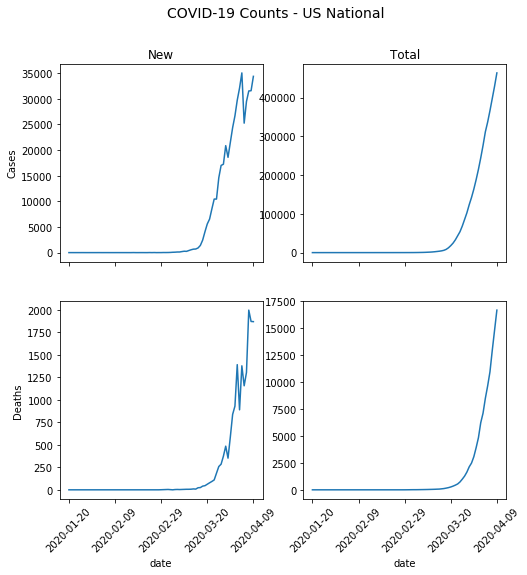

In [135]:
fig, ax = plt.subplots(2, 2, sharex='col',figsize=(8,8))
national.new_cases.plot(title='New',ax=ax[0,0])
ax[0,0].set_ylabel('Cases')
national.cases.plot(title='Total',ax=ax[0,1])
national.new_deaths.plot(ax=ax[1,0])
ax[1,0].set_ylabel('Deaths')
plt.setp(ax[1,0].xaxis.get_majorticklabels(), rotation=45)
national.deaths.plot(ax=ax[1,1])
plt.setp(ax[1,1].xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('COVID-19 Counts - US National', fontsize=14);

## Estimate Doubling Rates
In tracking the exponential growth phase we often hear of the *doubling rate*, i.e. the amount that it takes for the number of cases (or deaths) to double. COVID-19 is so viral that this time is measured in *days*.

In [136]:
# define a function that fits an exponential growth model to the input
# and returns the doubling time

def doubling_rate(y):
    b,lna = np.polyfit(range(0,len(y)), np.log(y), 1)
    return np.log(2)/b

Now we can compare doubling rates based on any slice of the data:

In [137]:
doubling_rate(national.deaths[-14:])

3.86892365938089

In [138]:
doubling_rate(national.new_deaths[-14:])

5.316965508588987

In [139]:
doubling_rate(national.cases[-14:])

6.026623697259936

In [140]:
doubling_rate(national.deaths[-4:])

4.958434960354029

Compute the doubling rate of US total deaths based ont the past 14 days of data and chart how that model compares to the actual data.

In [141]:
y = national.deaths[-14:]
b,lna = np.polyfit(range(0,len(y)), np.log(y), 1)
dr = np.log(2)/b
x=range(0,14)
y_pred = np.exp(lna)*np.exp(b*x)

In [142]:
pred=pd.DataFrame(y.index)
pred['y_pred'] = y_pred
pred.set_index('date',inplace=True)
tmp = national.join(pred,how='left')
tmp = tmp.loc[tmp.deaths>=1]

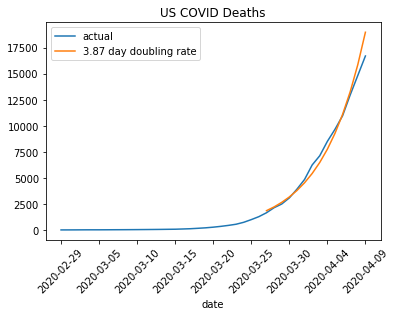

In [143]:
tmp.deaths.plot(title='US COVID Deaths',figsize=(6,4),label='actual',legend=True)
tmp.y_pred.plot(label='{:4.2f} day doubling rate'.format(dr),legend=True)
plt.xticks(rotation=45);

## Fit Logistic Function to US National Data
The virus cannot grow exponentially forever - at some time the number of deaths will plateau. We can model this slowdown as a logistic (sigmoid) function.

The code below is based on [this example](https://ipython-books.github.io/93-fitting-a-function-to-data-with-nonlinear-least-squares/)

In [144]:
import scipy.optimize as opt

# define a logistic function with 4 parameters a,b,c,d
def f(x, a, b, c, d):
    return ( a / (1. + np.exp(-c * (x - d))) ) + b

29665.72563394151 -11.725442864911857 0.23451657473323334 79.01437297429865


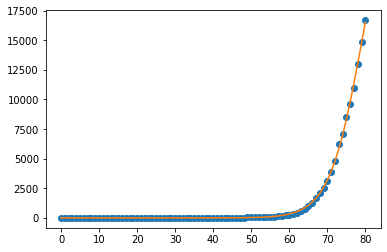

In [145]:
y = national.deaths
x = range(0,len(y))
(a, b, c, d), _ = opt.curve_fit(f, x, y,[20000,1,1,1])
y_fit = f(x,a,b,c,d)
print(a, b, c, d)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-');

Now use this model to project future deaths, let's go out to 180 days.

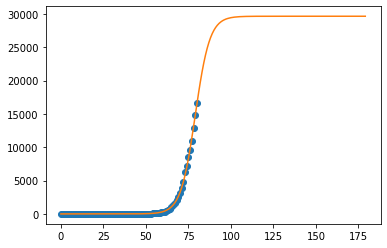

In [146]:
x_proj = range(0,180)
y_proj = f(x_proj,a,b,c,d)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x_proj, y_proj, '-');

This is far lower than the [range of projections from healthdata.org](https://covid19.healthdata.org/projections). There must be tremendous variance in the parameters or this curve is just not appropriate. Or possibly healthdata.org is modeling each state separately then summing the estimates to arrive at the national curve. This would make sense in that the state are generally out of phase with each other.

In [147]:
# show the covariance of the parameters from the fit
print(_)

[[ 8.33039161e+05 -2.60296159e+03 -2.97513719e+00  2.30597872e+02]
 [-2.60296159e+03  1.27691005e+02  1.37098867e-02 -6.78191294e-01]
 [-2.97513719e+00  1.37098867e-02  1.25481339e-05 -8.43476755e-04]
 [ 2.30597872e+02 -6.78191294e-01 -8.43476755e-04  6.44493281e-02]]
